In [2]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import tracking_utils #own helper package where I needed to navigate and then: pip install -e .
import pandas as pd
import numpy as np

#imports second part:
import argparse
import os
import cv2
import torch
from mivolo.predictor import Predictor

/usr/users/vhassle/miniforge3/envs/MOTIP/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## In this Part MOT results are made visible in the Video

In [6]:
#load the data
base_path = "/usr/users/vhassle/psych_track/MOTIP"
dataset_name = "Wortschatzinsel" #"test_results"


#until now just configured basically for one sequence can be adjusted if necceassary
output_dir = os.path.join(base_path, "outputs", dataset_name, "submit/default/r50_deformable_detr_motip_mot17/tracker")
#output_dir = os.path.join(base_path, "outputs", dataset_name, "submit/default/r50_deformable_detr_motip_mot17/tracker")
# Load data for one sequence
mot_data = tracking_utils.read_MOT(os.path.join(output_dir, "2024_05_04_10_00_24_top_view.txt"))
#mot_data = tracking_utils.read_MOT(os.path.join(output_dir, "test_sequence.txt"))



#MOT File results created by MOTIP are translated into the images and the annotated video of that clip
output_dir_visualization = os.path.join(output_dir, "top_view")
os.makedirs(output_dir_visualization, exist_ok=True)

#max([int(i) for i in list(set(mot_data["frame_name"]))])
frame_names = [f"{i:06d}" for i in range(1000)]

#for frame_name in tqdm(sorted(list(set(mot_data["frame_name"])))):
for frame_name in tqdm(frame_names):
    #subset the data for a specific frame
    mot_data_frame = mot_data[mot_data["frame_name"] == frame_name]

    image_path = os.path.join(base_path,"data/datasets/Wortschatzinsel/2024_05_04_10_00_24_top_view/img1",f"{frame_name}.jpg")
    #image_path = os.path.join(base_path,"data/datasets/test/test_sequence/img1",f"{frame_name}.jpg")
    output_path = os.path.join(output_dir_visualization,f"{frame_name}.jpg")
    if os.path.exists(output_path):
        #print(f"Skipping frame {frame_name} as output path already exists.")
        continue

    # plot the image with the bounding boxes predicted by the tracker
    # also ad the id_nr of the object

    example_image = Image.open(image_path)
    fig, ax = plt.subplots(1,1, figsize=(10, 15))
    for annotation, id_nr in zip(mot_data_frame["bbox_xywh"], mot_data_frame["id_nr"]):
        x_left, y_top, width, height = annotation
        rectangle = plt.Rectangle((x_left, y_top), width, height, edgecolor='r', facecolor="none")
        ax.add_patch(rectangle)
        ax.text(x_left, y_top+30, int(id_nr), fontsize=12, color="green")
    ax.imshow(example_image)
    #plt.show()

    ax.axis('off')
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
    #plt.show()
    plt.close()



100%|██████████| 1000/1000 [02:47<00:00,  5.98it/s]


In [8]:
output_dir_visualization

'/usr/users/vhassle/psych_track/MOTIP/outputs/Wortschatzinsel/submit/default/r50_deformable_detr_motip_mot17/tracker/top_view'

In [9]:
# Create a Video out of the images in the according folder overwriting the existing one
output_video_path = os.path.join(output_dir_visualization, 'test_video2.mp4')
cmd_str = f'/usr/users/vhassle/ffmpeg-6.0-amd64-static/ffmpeg -y -f image2 -r 30 -i {output_dir_visualization}/%06d.jpg -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" -vcodec libx264 -crf 18 -pix_fmt yuv420p {output_video_path}'
os.system(cmd_str)

ffmpeg version 6.0-static https://johnvansickle.com/ffmpeg/  Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 8 (Debian 8.3.0-6)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-debug --disable-ffplay --disable-indev=sndio --disable-outdev=sndio --cc=gcc --enable-fontconfig --enable-frei0r --enable-gnutls --enable-gmp --enable-libgme --enable-gray --enable-libaom --enable-libfribidi --enable-libass --enable-libvmaf --enable-libfreetype --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-librubberband --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libvorbis --enable-libopus --enable-libtheora --enable-libvidstab --enable-libvo-amrwbenc --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libdav1d --enable-libxvid --enable-libzvbi --enable-libzimg
  libavutil      58.  2.100 / 58.  2.100
  libavcodec     60.  3.100 / 60.  3.100
  libavformat    6

0

# Get age and Gender of the subjects

Model summary (fused): 268 layers, 68125494 parameters, 0 gradients, 257.4 GFLOPs
['female', 'female'] [36.47, 36.47]


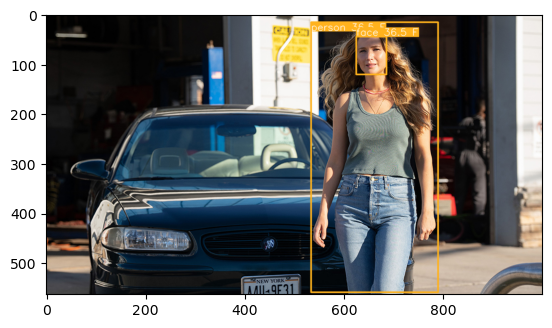

In [37]:
#mini example
os.chdir("/usr/users/vhassle/psych_track/MiVOLO")

class Args:
    def __init__(self):
        self.input = "jennifer_lawrence.jpg"
        self.output = "output"
        self.detector_weights = "models/yolov8x_person_face.pt"
        self.checkpoint = "models/mivolo_imbd.pth.tar"
        self.with_persons = True
        self.disable_faces = False
        self.draw = False
        self.device = "cuda"
args = Args()


images= args.input

if torch.cuda.is_available():
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.benchmark = True
os.makedirs(args.output, exist_ok=True)

predictor = Predictor(args, verbose=False)

for image in [images]:

    img = cv2.imread(image)
    detected_objects, out_im = predictor.recognize(img)
    gender_est = detected_objects.genders
    age_est = detected_objects.ages
    print(gender_est, age_est)
    image_cv = cv2.cvtColor(detected_objects.plot(), cv2.COLOR_BGR2RGB)
    plt.imshow(image_cv)
    plt.show()


In [46]:

os.chdir("/usr/users/vhassle/psych_track/MiVOLO")

#  For every Frame all MOT Detections are cut out and feeded into the yolo Network to estimate the age and the gender of the person shown in the image

#predifinyng the used arguments
class Args:
    def __init__(self):
        #self.input = ""
        #self.output = "output"
        self.detector_weights = "models/yolov8x_person_face.pt"
        self.checkpoint = "models/mivolo_imbd.pth.tar"
        self.with_persons = True
        self.disable_faces = False
        self.draw = False
        self.device = "cuda"

args = Args()
predictor = Predictor(args, verbose=False)



#for overview is redundant line defining the data used 

#get the MOT data
base_path = "/usr/users/vhassle/psych_track/MOTIP"
dataset_name = "Wortschatzinsel" #"test_results"
output_dir = os.path.join(base_path, "outputs", dataset_name, "submit/default/r50_deformable_detr_motip_mot17/tracker")
mot_data = tracking_utils.read_MOT(os.path.join(output_dir, "2024_05_04_10_00_24_top_view.txt"))
#mot_data = tracking_utils.read_MOT(os.path.join(output_dir, "test_sequence.txt"))

mot_data["gender"] = None
mot_data["age"] = None

#pseudocode:
for frame_name in tqdm(sorted(list(set(mot_data["frame_name"])))):#[175:]):
    #subset the data for a specific frame
    mot_data_frame = mot_data[mot_data["frame_name"] == frame_name]
    image_path = os.path.join(base_path,"data/datasets/Wortschatzinsel/2024_05_04_10_00_24_top_view/img1",f"{frame_name}.jpg")
    #image_path = os.path.join(base_path,"data/datasets/test/test_sequence/img1",f"{frame_name}.jpg")
    image = cv2.imread(image_path)
    # crop the image for each bounding box
    for annotation, id_nr in zip(mot_data_frame["bbox_xywh"], mot_data_frame["id_nr"]):
        annotation = [int(x) for x in annotation]
        x_left, y_top, width, height = annotation
        cropped_image = image[y_top:y_top+height, x_left:x_left+width]
        # plt.imshow(cropped_image)
        # plt.show()
        detected_objects, out_im = predictor.recognize(cropped_image)
        #if on the crop no person is detected gender and age stay None
        if detected_objects.n_persons == 0:
            continue
        elif detected_objects.n_persons > 1: #one could think to continue and wait that main person is seen solo smaller person should be recognized any way
            print(f"More than one person detected in frame {frame_name} for id {id_nr}")
            #plt.imshow(detected_objects.plot())
            ##plt.imshow(cropped_image)
            plt.show()
        mot_data.loc[(mot_data["frame_name"] == frame_name) & (mot_data["id_nr"] == id_nr), "gender"] = detected_objects.genders[0]
        mot_data.loc[(mot_data["frame_name"] == frame_name) & (mot_data["id_nr"] == id_nr), "age"] = np.mean(detected_objects.ages)
        
    
    

Model summary (fused): 268 layers, 68125494 parameters, 0 gradients, 257.4 GFLOPs


100%|██████████| 79/79 [00:06<00:00, 12.93it/s]


In [48]:
mot_data

,frame_nr,frame_name,id_nr,bbox_xywh,confidence_score
0,1,000001,0.0,"[1749.33, 517.02, 150.2, 176.41]",1.0
1,1,000001,1.0,"[971.72, 481.55, 51.92, 109.23]",1.0
2,1,000001,2.0,"[1207.17, 452.84, 76.09, 178.48]",1.0
3,1,000001,3.0,"[765.73, 458.57, 45.48, 127.97]",1.0
4,1,000001,4.0,"[899.84, 491.76, 53.73, 94.0]",1.0
...,...,...,...,...,...
5609,450,000450,12.0,"[605.23, 474.01, 27.41, 78.28]",1.0
5610,450,000450,65.0,"[874.61, 472.25, 32.36, 75.94]",1.0
5611,450,000450,80.0,"[1086.59, 501.29, 79.01, 106.29]",1.0
5612,450,000450,63.0,"[694.26, 466.44, 28.37, 82.73]",1.0


In [49]:
# Results per Id of the sequence
aggregations = {
    'age': lambda x: np.mean(x) ,  # Mean of the age
    'gender': lambda x: x.value_counts().idxmax() if not x.dropna().empty else None,
    'frame_nr': ['first', 'last'],
}

results_per_id = mot_data.groupby('id_nr').agg(aggregations).reset_index()

KeyError: "Column(s) ['age', 'gender'] do not exist"

In [84]:
results_per_id["age"].min()

<lambda>    27.62
dtype: float64